Evolving in time: 100%|██████████| 400000/400000 [2:32:21<00:00, 43.76it/s]     


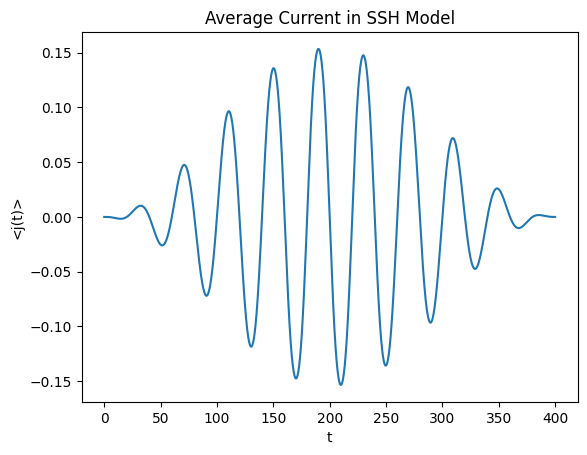

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Parameters
t1, t2 = 2.0, 1.0
A0 = 0.5
Nc = 10
omega0 = np.pi / (2 * Nc)
dt = 0.001
Nk = 251
dk = 2 * np.pi / Nk
k_values = np.linspace(-np.pi, np.pi, Nk, endpoint=False)

T = 2 * np.pi * Nc / omega0
Nt = int(T / dt)

# Initial density matrix (same for each k)
rho0 = np.array([[0, 0],
                 [0, 1]], dtype=complex)
rho_k = np.tile(rho0, (Nk, 1, 1))

# Field
def A_t(t):
    return A0 * np.sin(omega0 * t) * (np.sin(omega0 * t / (2 * Nc)))**2

# Hamiltonian in eigenbasis (analytic form)
def H_elements(k, At):
    denom = np.sqrt(t1**2 + t2**2 + 2*t1*t2*np.cos(k))
    Hpp = (t2**2*np.cos(At) + t1**2 + t1*t2*(np.cos(k) + np.cos(k - At))) / denom
    Hmm = -Hpp
    Hpm = 1j*t2*(t2*np.sin(At) + t1*(np.sin(k) - np.sin(k - At))) / denom
    Hmp = -Hpm
    return np.array([[Hpp, Hpm],
                     [Hmp, Hmm]], dtype=complex)

# Current operator (Eq. 8)
def current_operator(k, At):
    denom = np.sqrt(t1**2 + t2**2 + 2*t1*t2*np.cos(k))
    Hpp = (t2**2*np.cos(At) + t1**2 + t1*t2*(np.cos(k) + np.cos(k - At))) / denom
    Hmm = -Hpp
    Hpm = 1j*t2*(t2*np.sin(At) + t1*(np.sin(k) - np.sin(k - At))) / denom
    Hmp = -Hpm

    # Analytic derivative wrt k gives current terms
    dHpp = -t1*t2*np.sin(k)/denom
    dHmm = -dHpp
    dHpm = 1j*t1*t2*np.cos(k)/denom
    dHmp = -dHpm

    return np.array([[dHpp, dHpm],
                     [dHmp, dHmm]], dtype=complex)

# Commutator
def commutator(A, B):
    return A @ B - B @ A

# Time evolution
avg_current = []

for n in tqdm(range(Nt), desc="Evolving in time"):
    t = n * dt
    At = A_t(t)
    j_total = 0.0

    # Vectorized over k
    for i, k in enumerate(k_values):
        H = H_elements(k, At)
        drho = -1j * commutator(H, rho_k[i])
        rho_k[i] += dt * drho

        J = current_operator(k, At)
        j_total += np.trace(J @ rho_k[i]).real * dk / (2*np.pi)

    avg_current.append(j_total)

# Plot
time = np.linspace(0, T, Nt)
plt.plot(time, avg_current)
plt.xlabel("t")
plt.ylabel("<j(t)>")
plt.title("Average Current in SSH Model")
plt.show()

